# Across scenario basic analysis

### Load packages

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline

import scipy.stats
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
#display all columns
pd.set_option('display.max_columns', None)

## Theming

In [3]:
sns.set_style("white")

### Helper functions

In [4]:
#helper function for pd.agg
def item(x):
    """Returns representative single item"""
    return x.tail(1).item()

### Set up directory paths to plots and data

In [5]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

## Load in data

Assumes exported csvs from `basic_analysis.ipynb` in results folder

In [6]:
studies = [
    "drop_pilot",
    "collision_pilot",
    "rollingsliding_pilot",
    "dominoes_pilot",
    "clothiness_pilot",
    "towers_pilot",
    "linking_pilot",
    "containment_pilot",
]

In [22]:
ls `echo $csv_dir/'humans'`

human_accuracy-clothiness_pilot-production_2_testing.csv
human_accuracy-collision_pilot-production_2_testing.csv
human_accuracy-containment_pilot-production_2_testing.csv
human_accuracy-dominoes_pilot-production_1_testing.csv
human_accuracy-drop_pilot-production_2_testing.csv
human_accuracy-linking_pilot-production_2_testing.csv
human_accuracy-rollingsliding_pilot-production_2_testing.csv
human_accuracy-towers_pilot-production_2_testing.csv
human_responses-clothiness_pilot-production_2_testing.csv
human_responses-collision_pilot-production_2_testing.csv
human_responses-containment_pilot-production_2_testing.csv
human_responses-dominoes_pilot-production_1_testing.csv
human_responses-drop_pilot-production_2_testing.csv
human_responses-linking_pilot-production_2_testing.csv
human_responses-rollingsliding_pilot-production_2_testing.csv
human_responses-towers_pilot-production_2_testing.csv


In [45]:
#load all experiments as one dataframe
prefix = "human_responses-"
suffix = lambda s: "-production_%d_testing" % (1 if 'dominoes' in s else 2)
make_fname = lambda s: prefix + s + suffix(s) + ".csv"
df = []
for l in studies:
    _df = pd.read_csv(os.path.join(csv_dir, 'humans', make_fname(l)))
    if 'study' not in _df.columns:
        _df = _df.assign(study=[l] * len(_df), axis=0)
    df.append(_df)
df = pd.concat(df)
# df = pd.concat([pd.read_csv(os.path.join(csv_dir, 'humans', make_fname(l))) for l in studies])
print("Loaded dataframes")

Loaded dataframes


In [46]:
df['study']

0               drop_pilot
1               drop_pilot
2               drop_pilot
3               drop_pilot
4               drop_pilot
               ...        
15145    containment_pilot
15146    containment_pilot
15147    containment_pilot
15148    containment_pilot
15149    containment_pilot
Name: study, Length: 120450, dtype: object

In [47]:
#save nice scenario name
df['scenario'] = df['study'].apply(lambda x: x.split('_')[0])

In [48]:
#sort by it
df.sort_values('scenario',inplace=True)

In [49]:
#subtract stimulus presentation time from reaction time
df['rt'] = df['rt'] - 2500

In [50]:
#drop reaction times longer than 10 seconds
df['rt'] = df['rt'].apply(lambda x: x if x < 10000 else np.nan)

In [51]:
def outcome_helper(correct,response):
    response = response == "YES"
    if correct and response: return "hit"
    if not correct and response: return "false_alarm"
    if correct and not response: return "correct_rejection"
    if not correct and not response: return "miss"

In [52]:
#encode response kind
df['outcome'] = [outcome_helper(correct, response) for correct, response in zip(df['correct'],df['response'])]

In [53]:
df['outcome'].value_counts()

hit                  46011
correct_rejection    43379
false_alarm          16846
miss                 14214
Name: outcome, dtype: int64

In [307]:
df['target_hit_zone_label'][0:1]

224    True
Name: target_hit_zone_label, dtype: bool

## Plots

### Per stimulus

In [54]:
df['response'] = df['response'] == "YES" #encode response as boolean

In [481]:
df['c'] = 1
df['distractors_list'] = df['distractors'].apply(lambda x: x[1:-1].split(','))
# df['num_occluders'] = df['occluders'].apply(lambda x: len(x[1:-1].split(',')))

In [457]:
df['num_distractors'][-3:]

10242     2
10254    26
7799      2
Name: num_distractors, dtype: int64

In [414]:
per_stim_agg = df.groupby('stim_ID').agg({
    'scenario' : lambda s: s.head(1),
    'correct' : lambda cs: np.mean([1 if c == True else 0 for c in cs]),
    'response' : 'mean',
    'c' : 'count',
    'stim_url' : lambda s: s.head(1),
    'hdf5_url' : lambda s: s.head(1),
    'target_hit_zone_label': 'mean',
    'num_distractors': 'mean',
    'num_occluders': 'mean'
})
per_stim_agg.sort_values('scenario',inplace=True)

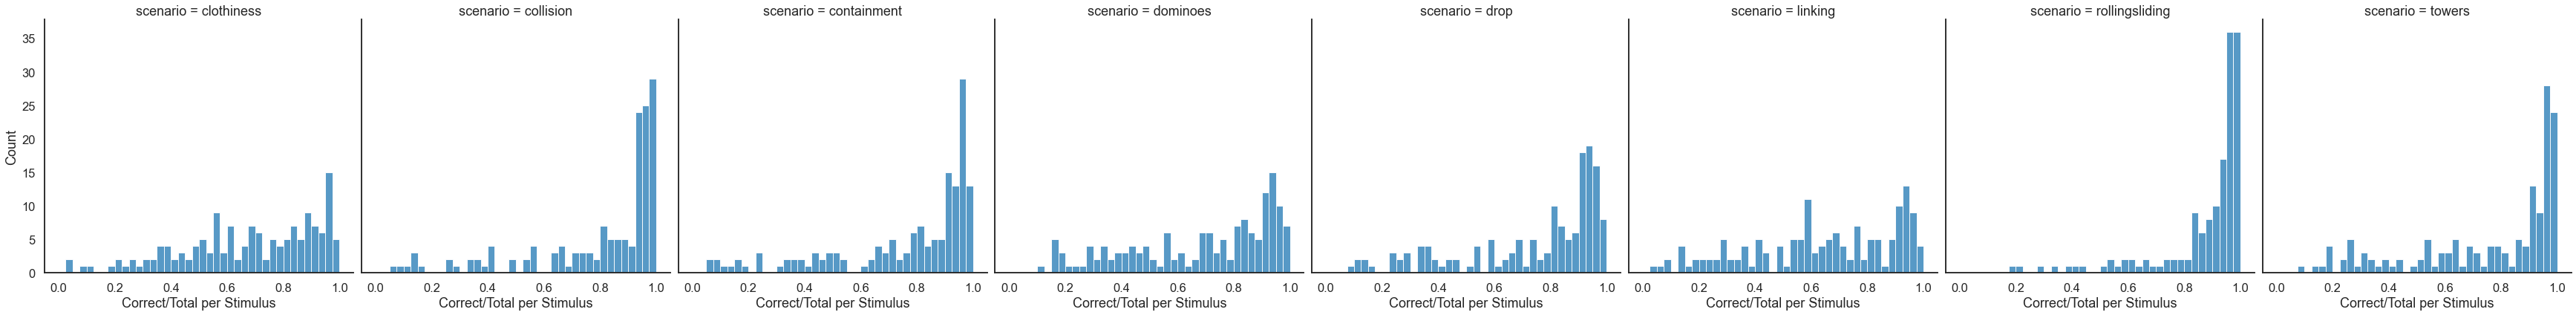

In [66]:
g = sns.FacetGrid(per_stim_agg, col="scenario", height=6)
g.map(sns.histplot, "correct", bins=40, binrange=[0,1])
g.set_axis_labels("Correct/Total per Stimulus","Count")
# g.savefig(os.path.join(plot_dir,"per_stim_16.pdf"))

Individual plots

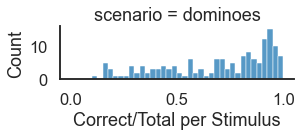

In [67]:
scenario = "dominoes"

g = sns.FacetGrid(per_stim_agg.query("scenario == @scenario"), col="scenario", height=2, aspect=2)
g.map(sns.histplot, "correct", bins=40, binrange=[0,1])
g.set_axis_labels("Correct/Total per Stimulus","Count")
# g.savefig(os.path.join(plot_dir,"per_stim_"+scenario+".pdf"))

In [68]:
per_stim_agg.query("scenario == @scenario")

,scenario,correct,response,c,stim_url
stim_ID,,,,,
pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0029_img,dominoes,0.98,0.98,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0007_img,dominoes,0.74,0.74,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0008_img,dominoes,0.42,0.58,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0012_img,dominoes,0.91,0.09,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0014_img,dominoes,0.81,0.81,100,https://human-physics-benchmarking-dominoes-pi...
...,...,...,...,...,...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0023_img,dominoes,0.68,0.32,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024_img,dominoes,0.72,0.28,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0025_img,dominoes,0.87,0.13,100,https://human-physics-benchmarking-dominoes-pi...


### Easy & adversarial example cases
> Easy, hard, chance, adversarial; reliable, noisy

In [285]:
import h5py
import cv2
from PIL import Image

def download_stims(stims, suffix='mp4'):
    if suffix == 'mp4':
        key, _dir = 'stim_url', 'mp4s'
    elif suffix == 'hdf5':
        key, _dir = 'hdf5_url', 'hdf5s'
    elif suffix == 'map':
        key, _dir = 'map_url', 'maps'
    else:
        raise NotImplementedError(suffix)

    p = !pwd
    p = p[0]
    files = []
    for i in range(len(stims)):
        url = stims[key][i]
        fname = url.split('/')[-1]
        outname = os.path.join(p, _dir, fname)
        if not os.path.exists(outname):
            !wget `echo $url` -O `echo $outname`
        else:
            print("%s already exists" % fname)
        files.append(outname)
    return files
    
def get_frame_mp4(fname, frame_num=0):
    assert fname[-4:] == '.mp4', fname
    cap = cv2.VideoCapture(fname)
    if (cap.isOpened() == False):
        print("Error opening video stream")
    
    count = -1
    frame = None
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            count += 1            
        else:
            break
        
        if count == frame_num:
            break
            
    cap.release()
    cv2.destroyAllWindows()
    
    if frame is not None:
        frame = np.stack([frame[...,c] for c in [2,1,0]], -1)

    return frame

def get_frame_hdf5(fname, frame_num=0, imkey='_img'):
    
    assert fname [-5:] == '.hdf5', fname
    f = h5py.File(fname)
    frames = sorted(list(f['frames'].keys()))
    images = f['frames'][frames[frame_num]]['images']
    im = images[imkey]
    try:
        im = Image.open(io.BytesIO(im[:]))    
    except:
        im = np.array(im)
    f.close()
    return np.array(im)

In [374]:
### plotting ###

def read_depth_im(depth, depth_max=10.0):
    '''convert a [H,W,3] uint8 to a [H,W] depth image'''
    assert depth.shape[-1] == 3, depth.shape
    H,W,C = depth.shape
    depth = np.split(depth, C, axis=-1)
    out = np.zeros([H,W], dtype=np.float32)
    for c,d in enumerate(depth):
        out += d[...,0] * (256 ** (C - 1 - c))
    out *= 100.1
    out /= 256**3
    
    mask = (out <= depth_max).astype(float)
    out = mask * out + depth_max * (1-mask)
    return out

def get_movie_frames(stim, start_frame=0, end_frame=150, num_plots=6, from_hdf5=False):
    '''Get evenly spaced frames from a stim'''
    if 'pandas' in str(type(stim[0:1])):        
        stim = download_stims(stim, 'hdf5' if from_hdf5 else 'mp4')[0]
    else:
        assert isinstance(stim, str), (stim, type(stim))
        assert ('.mp4' in stim) or ('.hdf5' in stim), stim
    _get_func = get_frame_hdf5 if from_hdf5 else get_frame_mp4
    fnums = [int(d) for d in np.linspace(start_frame, end_frame, num_plots)]
    frames = [_get_func(stim, frame_num=n) for n in fnums]
    return frames

def plot_movie(axes, stim, start_frame=0, end_frame=150, num_plots=6, from_hdf5=False):
    if axes is None:
        fig, axes = plt.subplots(1,num_plots, figsize=(num_plots * 4, 4))
        
    frames = get_movie_frames(stim, start_frame, end_frame, num_plots, from_hdf5)
    fnums = [int(d) for d in np.linspace(start_frame, end_frame, num_plots)]
    for i,fr in enumerate(frames):
        axes[i].imshow(fr)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title('T = %d' % fnums[i])
        
def plot_movies(stims, start_frame=0, end_frame=150, num_plots=6, from_hdf5=False, savename=None):
    
    num_stims = len(stims)
    fig, axes = plt.subplots(num_stims, num_plots, figsize=(num_plots * 4, num_stims * 4), sharex=True, sharey=True)
    for row in range(num_stims):
        stim = stims[row:row+1]
        if num_stims > 1:
            ax = axes[row]
        else:
            ax = axes
        plot_movie(ax, stim, start_frame, end_frame, num_plots, from_hdf5)
        if row != 0:
            for col in range(num_plots):
                ax[col].set_title('')
        ax[0].set_ylabel(("label = %s" % stim['target_hit_zone_label'][0]) + "\n" + ("acc = %.3f" % stim['correct'][0]))
    if savename is not None:
        plt.savefig(savename)
    plt.show()

def plot_passes(stim, frame_num=0, passes=['_img', '_id', '_depth', '_normals', '_flow'], 
                depth_max=10.0, flow_scale_factor=10.0):
    if len(stim) > 1:
        stim = stim[0:1]
    if 'pandas' in str(type(stim[0:1])):        
        stim = download_stims(stim, 'hdf5')[0]
    else:
        assert isinstance(stim, str), (stim, type(stim))
        assert ('.hdf5' in stim), stim    
    
    ims = []
    for p in passes:
        im = get_frame_hdf5(stim, frame_num, imkey=p)
        if p == '_depth':
            im = read_depth_im(im, depth_max=depth_max)
        if p == '_flow':
            im = (im / 255.) * flow_scale_factor
        ims.append(im)
        
    fig, axes = plt.subplots(1, len(passes), figsize=(len(passes) * 4, 4), sharex=True, sharey=True)
    for i,im in enumerate(ims):
        axes[i].imshow(im)
        axes[i].set_title(passes[i][1:])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    plt.show()


pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0017.hdf5 already exists


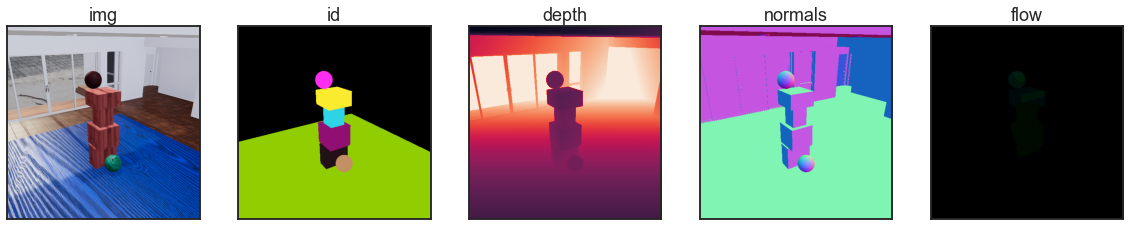

In [365]:
plot_passes(selection[2:3], frame_num=200, depth_max=10.0, flow_scale_factor=10)

pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_0000_img.mp4 already exists
pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_0016_img.mp4 already exists
pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0017_img.mp4 already exists


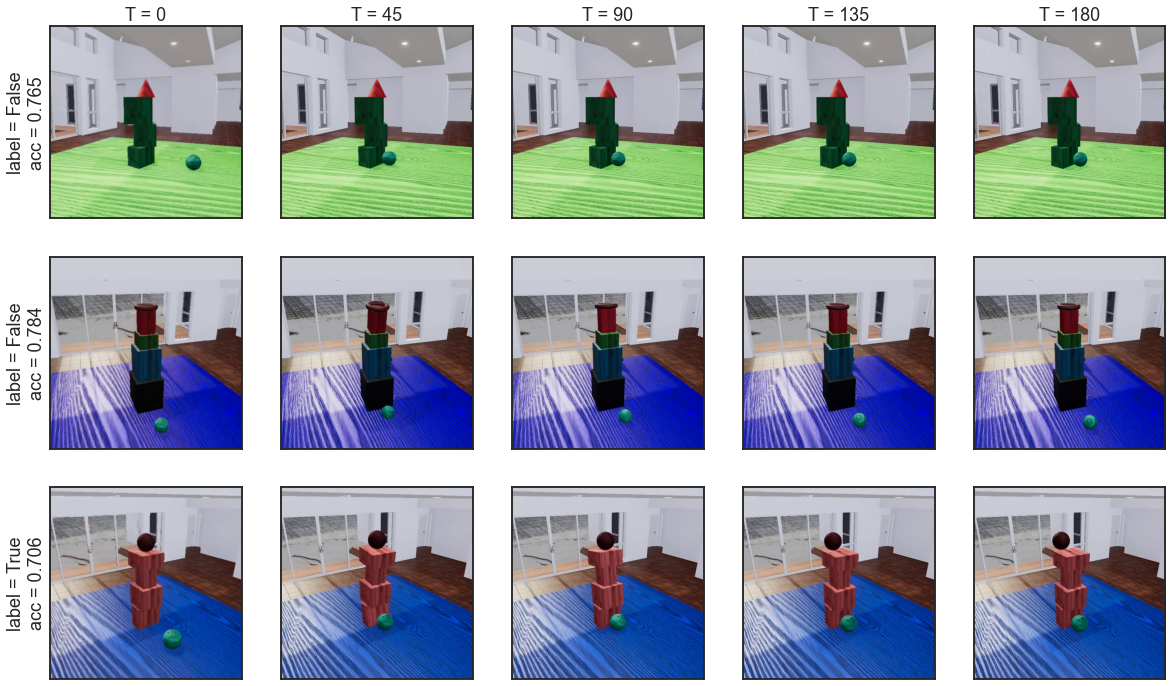

In [347]:
plot_movies(selection[0:3], start_frame=0, end_frame=180, num_plots=5)

pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_0016_img.mp4 already exists


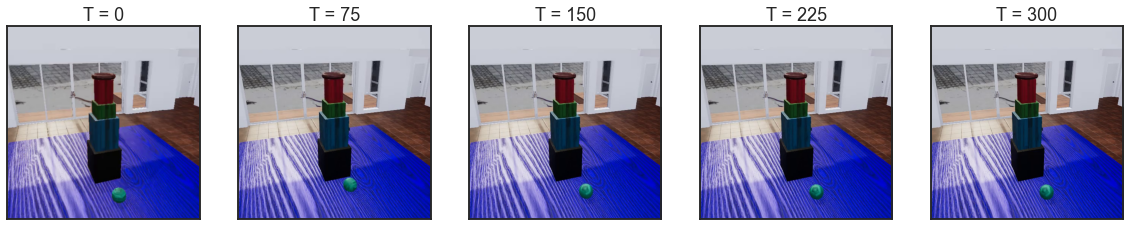

In [366]:
plot_movie(None, selection[1:2], 0, 300, 5)
plt.show()

pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0029_img.mp4 already exists
pilot_dominoes_4mid_boxroom_2_0004_img.mp4 already exists
pilot_dominoes_4mid_boxroom_0001_img.mp4 already exists


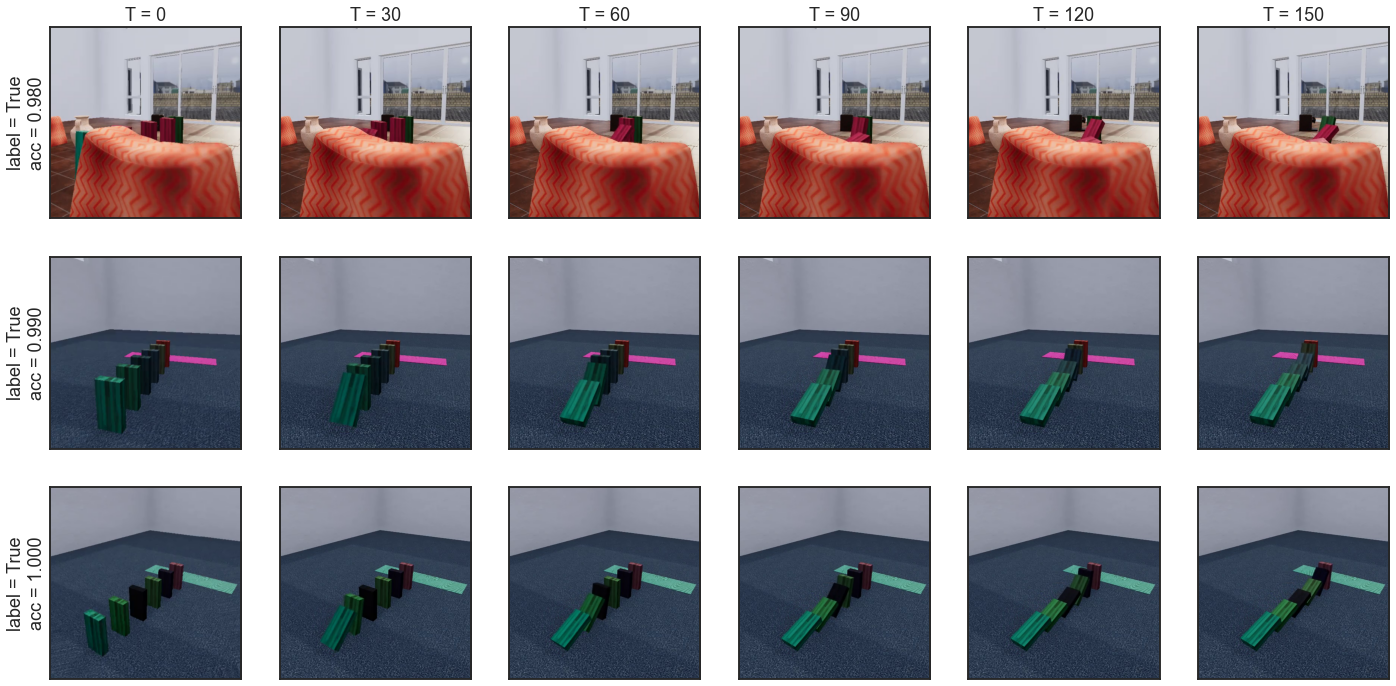

In [375]:
scenario = 'dominoes'
df_s = per_stim_agg[per_stim_agg['scenario'] == scenario]
df_s = df_s.sort_values('correct')
selection = df_s[-3:]

plot_movies(selection, 0, 150, 6, savename='dominoes.svg')

## Get the easiest stim from each scenario and plot it

In [421]:
per_stim_agg.sort_values('num_occluders')[-3:]

,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label,num_distractors,num_occluders
stim_ID,,,,,,,,,
pilot_it2_drop_all_bowls_box_2_dis_2_occ_0005_img,drop,0.90,0.90,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,True,31,62
pilot_it2_drop_all_bowls_box_2_dis_2_occ_0006_img,drop,0.97,0.03,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,False,23,63
pilot_it2_drop_all_bowls_tdw_2_dis_2_occ_0004_img,drop,0.91,0.91,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,True,38,67


In [488]:
easiest = []
for scenario in sorted(per_stim_agg['scenario'].unique()):
    df_s = per_stim_agg[per_stim_agg['scenario'] == scenario]
    df_s = per_stim_agg[(per_stim_agg['distractors'] == '[]') & (per_stim_agg['occluders'] == '[]')]
    df_s = df_s.sort_values('correct')[-1:]
    easiest.append(df_s)
easiest = pd.concat(easiest)
plot_movies(easiest, start_frame=0, end_frame=135, num_plots=4)

KeyError: 'distractors'

In [370]:
num_stims = 3

for scenario in per_stim_agg['scenario'].unique():
    print("*****",scenario,"*****")
    df_s = per_stim_agg[per_stim_agg['scenario'] == scenario]
    df_s = df_s.sort_values('correct')
    #get easy stims
    selection = df_s[df_s['correct']>0.90].sample(num_stims)
    print("---- Easy stims ----")
    display(selection)
    print(list(selection['stim_url']),"\n")
   #get hard stims
    selection = df_s[(df_s['correct']>0.70) & (df_s['correct']<0.80)].sample(num_stims)
    print("---- Hard stims ----")
    display(selection)
    print(list(selection['stim_url']),"\n")
#     #get chance stims
#     selection = df_s[(df_s['correct']>0.45) & (df_s['correct']<0.55)].sample(num_stims)
#     print("---- Chance stims ----")
#     display(selection)
#     print(list(selection['stim_url']),"\n")
#     #get adversarial stims
# #     selection = df_s[df_s['correct']<0.20].sample(num_stims)
#     selection = df_s.head(num_stims)
#     print("---- Adversarial stims ----")
#     display(selection)
#     print(list(selection['stim_url']),"\n")

***** clothiness *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
test11_0003_img,clothiness,0.95,0.05,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,False
test14_0013_img,clothiness,0.94,0.06,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,False
test13_0002_img,clothiness,0.96,0.04,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,False


['https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test11_0003_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test14_0013_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test13_0002_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
test12_0001_img,clothiness,0.72,0.72,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,True
test12_0003_img,clothiness,0.78,0.78,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,True
test16_0008_img,clothiness,0.76,0.76,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,True


['https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test12_0001_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test12_0003_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test16_0008_img.mp4'] 

***** collision *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_it2_collision_yeet_box_0002_img,collision,0.98,0.02,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,False
pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0009_img,collision,0.94,0.94,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,True
pilot_it2_collision_non-sphere_box_0004_img,collision,0.93,0.07,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,False


['https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_yeet_box_0002_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0009_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_non-sphere_box_0004_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_it2_collision_simple_box_2_dis_2_occ_0008_img,collision,0.73,0.73,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,True
pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0000_img,collision,0.71,0.71,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,True
pilot_it2_collision_tiny_ball_tdw_1_dis_1_occ_0004_img,collision,0.74,0.26,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,False


['https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_simple_box_2_dis_2_occ_0008_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0000_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_tiny_ball_tdw_1_dis_1_occ_0004_img.mp4'] 

***** containment *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot-containment-bowl_0023_img,containment,0.990099,0.009901,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,False
pilot-containment-box_0016_img,containment,0.970297,0.970297,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,True
pilot-containment-bowl_0026_img,containment,0.970297,0.029703,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,False


['https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-bowl_0023_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-box_0016_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-bowl_0026_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot-containment-bowl_0014_img,containment,0.792079,0.792079,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,True
pilot-containment-box_0015_img,containment,0.702970,0.702970,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,True
pilot-containment-torus_0009_img,containment,0.722772,0.277228,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,False


['https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-bowl_0014_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-box_0015_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-torus_0009_img.mp4'] 

***** dominoes *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0007_img,dominoes,0.95,0.05,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,False
pilot_dominoes_4midRM1_tdwroom_0000_img,dominoes,0.95,0.05,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,False
pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0029_img,dominoes,0.92,0.92,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,True


['https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_1mid_J025R45_o1full_tdwroom_0007_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_4midRM1_tdwroom_0000_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0029_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_dominoes_2mid_J025R30_tdwroom_0007_img,dominoes,0.74,0.74,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,True
pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0012_img,dominoes,0.71,0.71,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,True
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024_img,dominoes,0.72,0.28,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,False


['https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J025R30_tdwroom_0007_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0012_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024_img.mp4'] 

***** drop *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_it2_drop_sizes_tdw_1_dis_1_occ_0007_img,drop,0.94,0.94,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,True
pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0007_img,drop,0.93,0.07,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,False
pilot_it2_drop_sizes_tdw_1_dis_1_occ_0008_img,drop,0.93,0.07,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,False


['https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sizes_tdw_1_dis_1_occ_0007_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0007_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sizes_tdw_1_dis_1_occ_0008_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0003_img,drop,0.73,0.27,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,False
pilot_it2_drop_sidezone_tdw_2_dis_2_occ_0005_img,drop,0.78,0.78,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,True
pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0009_img,drop,0.75,0.25,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,False


['https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0003_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_tdw_2_dis_2_occ_0005_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0009_img.mp4'] 

***** linking *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0022_img,linking,0.94,0.06,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,False
pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0012_img,linking,0.96,0.04,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,False
pilot_linking_nl1-8_ms03_aCylcap_bCyl_occ1_dis1_tdwroom_0012_img,linking,0.91,0.91,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,True


['https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0022_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0012_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-8_ms03_aCylcap_bCyl_occ1_dis1_tdwroom_0012_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0023_img,linking,0.76,0.76,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,True
pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroom_0010_img,linking,0.75,0.75,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,True
pilot_linking_nl1-8_ms03_aCylcap_bCyl_occ1_dis1_tdwroom_0002_img,linking,0.79,0.79,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,True


['https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0023_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroom_0010_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-8_ms03_aCylcap_bCyl_occ1_dis1_tdwroom_0002_img.mp4'] 

***** rollingsliding *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_it2_rollingSliding_simple_collision_box_2_dis_2_occ_0000_img,rollingsliding,0.96,0.04,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,False
pilot_it2_rollingSliding_simple_ledge_box_0006_img,rollingsliding,0.99,0.99,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,True
pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0003_img,rollingsliding,0.93,0.07,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,False


['https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_collision_box_2_dis_2_occ_0000_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ledge_box_0006_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0003_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_it2_rollingSliding_simple_collision_box_0002_img,rollingsliding,0.76,0.24,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,False
pilot_it2_rollingSliding_simple_ramp_box_2_dis_2_occ_0010_img,rollingsliding,0.74,0.26,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,False
pilot_it2_rollingSliding_simple_ledge_box_1_dis_1_occ_0010_img,rollingsliding,0.77,0.77,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,True


['https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_collision_box_0002_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ramp_box_2_dis_2_occ_0010_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ledge_box_1_dis_1_occ_0010_img.mp4'] 

***** towers *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_0015_img,towers,0.970588,0.970588,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True
pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0011_img,towers,0.931373,0.931373,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True
pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0005_img,towers,0.901961,0.098039,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False


['https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_0015_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0011_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0005_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url,target_hit_zone_label
stim_ID,,,,,,,
pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0016_img,towers,0.754902,0.754902,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True
pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_occ1_boxroom_0010_img,towers,0.764706,0.764706,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True
pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0018_img,towers,0.784314,0.215686,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False


['https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0016_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_occ1_boxroom_0010_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0018_img.mp4'] 



In [76]:
df['occluders'].iloc[3]

'[]'

## Saving out relevant data

In [ ]:
pd.DataFrame(df['sessionID'].unique()).to_csv(os.path.join(csv_dir,"sessionIDs.csv"))